In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch import nn
from tqdm.notebook import tqdm
from torchsummary import summary
from torchvision import datasets
from torchvision import transforms


from utils import read_machine_data
from utils import softclip
from utils import plot_train_test_reconstructions
from models.cnn_sigmaVAE import CNN_sigmaVAE

import evaluation_utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [2]:
window_size=32
batch_size=256
X_train_data, X_test_data, X_train_tensor, X_test_tensor, df_Y_test, trainloader, testloader = read_machine_data('../../datasets/ServerMachineDataset/machine-1-1', window_size, batch_size)
 

torch.Size([889, 1, 32, 38]) torch.Size([889, 1, 32, 38])


In [3]:
def train_model(model, num_epochs, learning_rate, dataloader):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    epochs=num_epochs
    tq = tqdm(range(epochs))
    
    losses = []
    
    for epoch in tq:
        flag = False
        for j, data in enumerate(dataloader, 0):

            model.train()
            
            optimizer.zero_grad()

            #batches
            inputs, labels = data
            inputs = inputs.cuda() if torch.cuda.is_available() else inputs.cpu()
            inputs.to(device)
            labels = labels.cuda() if torch.cuda.is_available() else labels.cpu()
            labels.to(device)

            outputs, rec_mu, rec_sigma, kl = model(inputs)

            rec_comps, rec, rec_mu_sigma_loss, kl = model.loss_function(outputs, labels, rec_mu, rec_sigma, kl)

            loss = rec + kl + rec_mu_sigma_loss

            if(np.isnan(loss.item())):
                print("Noped out at", epoch, j, kl, rec_comps)
                flag = True
                break

            loss.backward()
            optimizer.step()
        if(flag):
            break
        tq.set_postfix(loss=loss.item())
        #print(epoch, 'total :' + str(loss.item()) + ' rec : ' + str(rec.item()) + ' kl : ' + str(kl.sum().item()) + ' sigma: ' + str(model.log_sigma.item()))

        losses.append(loss)
        
        #break
        
    plt.plot(losses)
    plt.show()
    
    return model

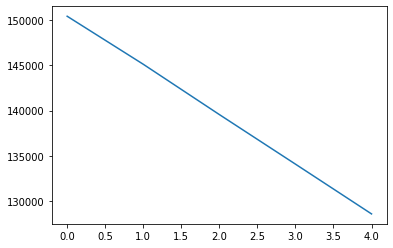

In [4]:
window_size=32
latent_dim=8
model = CNN_sigmaVAE(latent_dim, window_size).to(device)
model.cuda() if torch.cuda.is_available() else model.cpu()

model = train_model(model, 5, .005, trainloader)

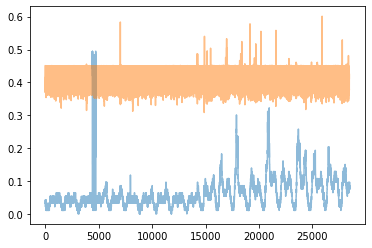

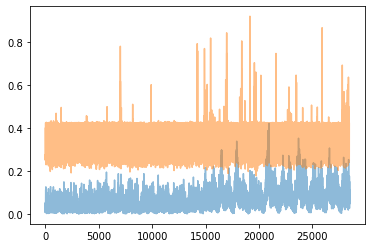

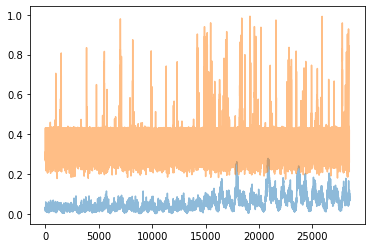

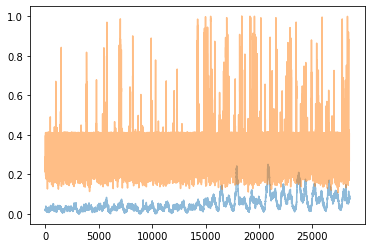

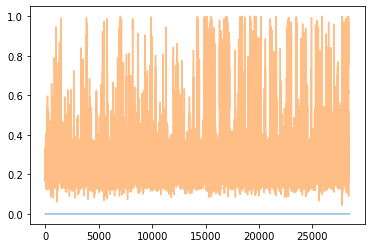

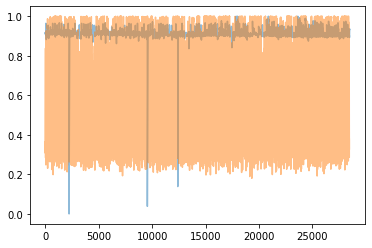

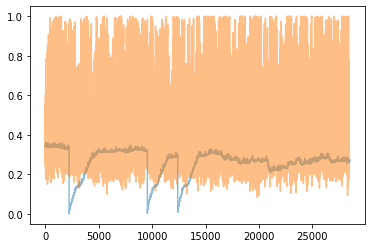

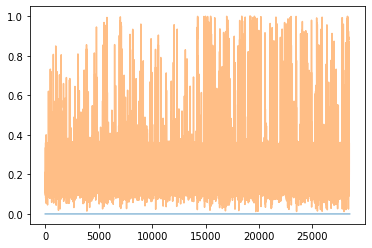

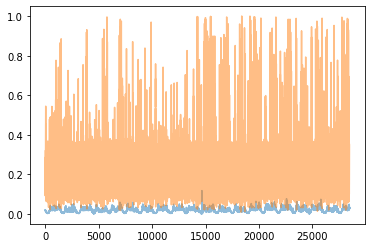

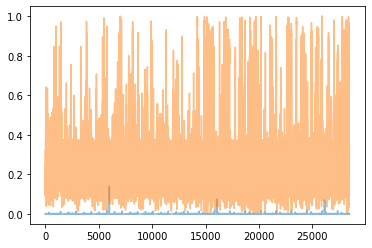

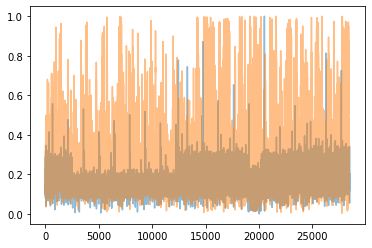

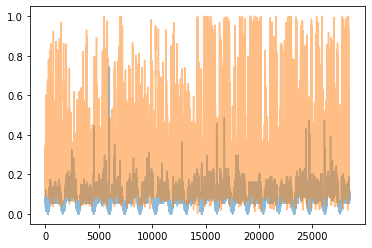

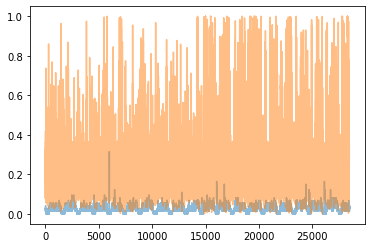

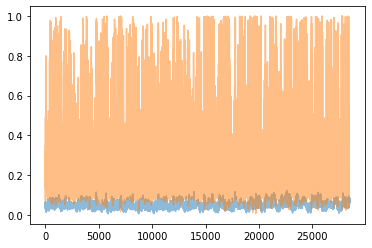

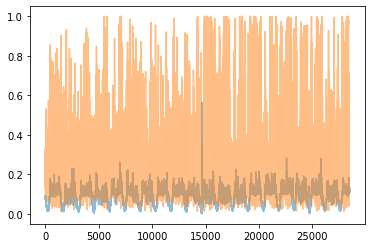

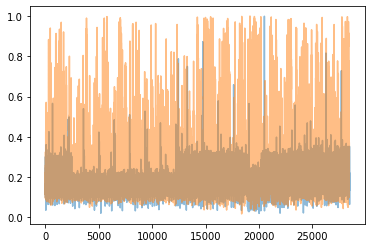

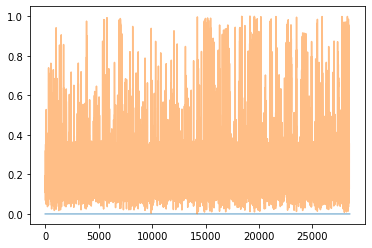

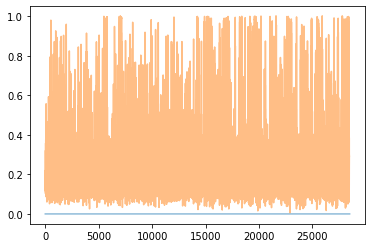

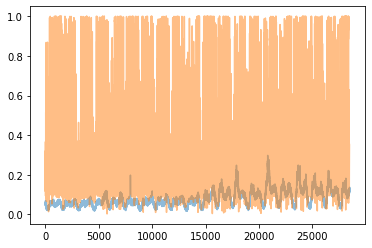

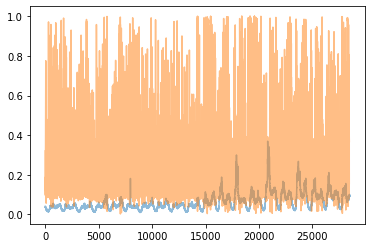

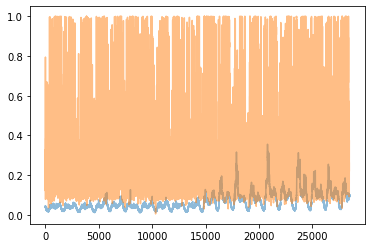

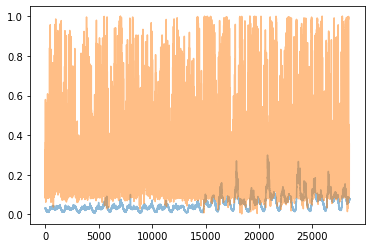

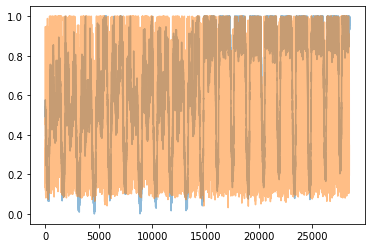

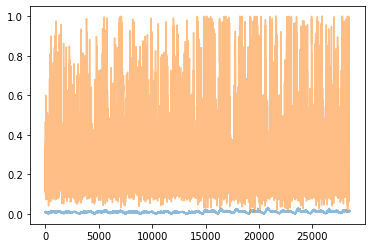

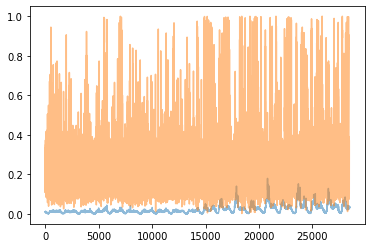

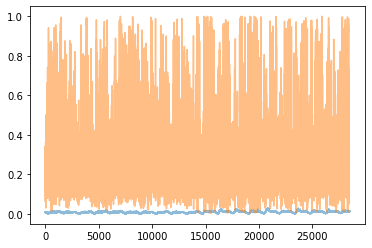

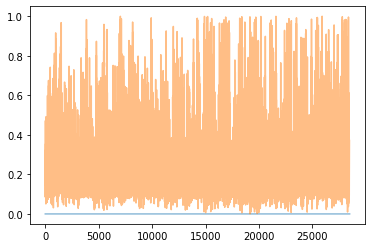

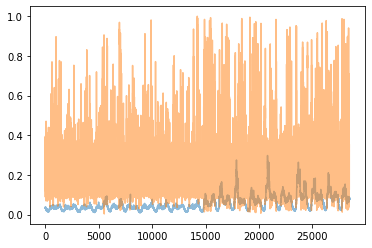

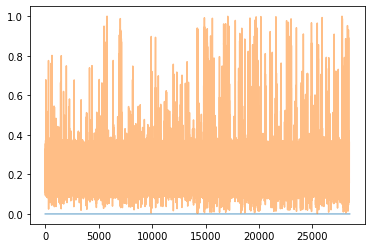

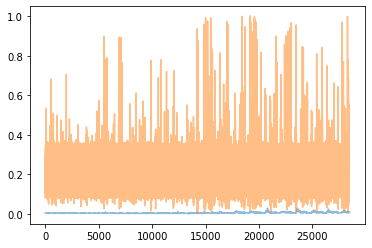

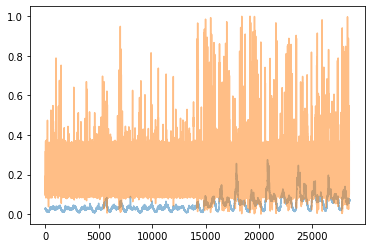

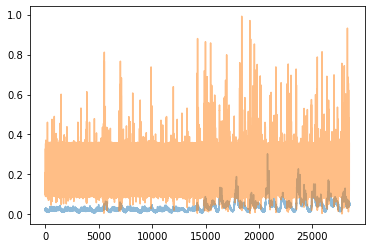

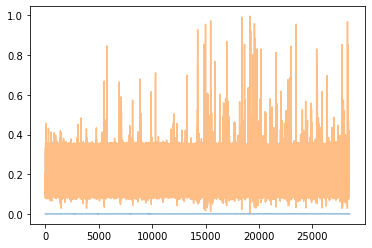

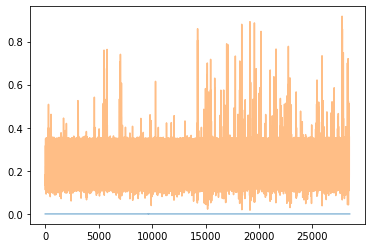

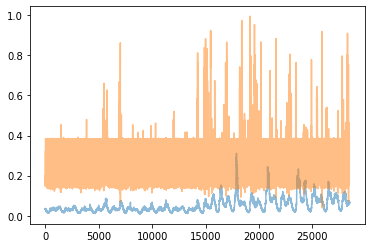

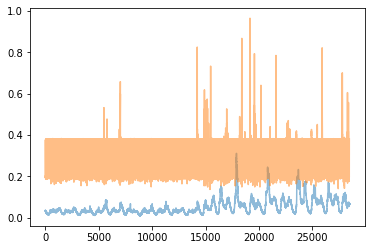

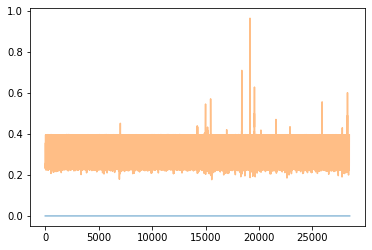

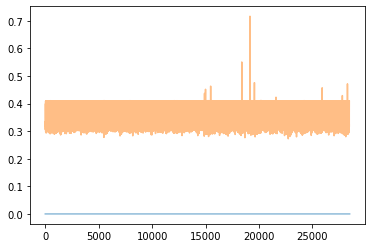

MSE : 0.07961


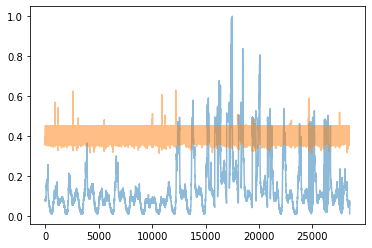

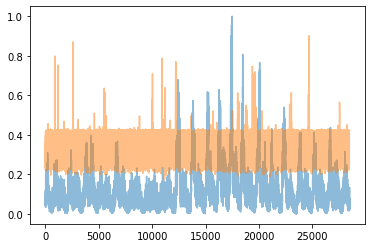

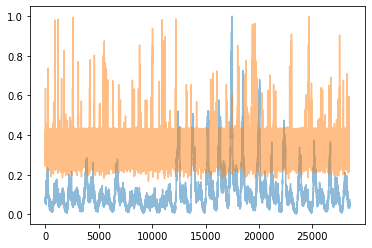

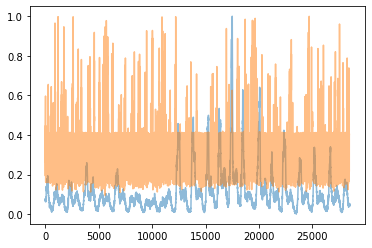

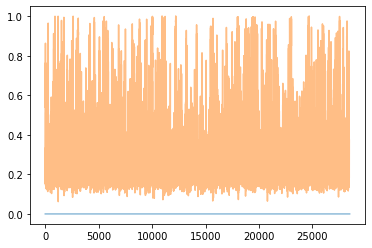

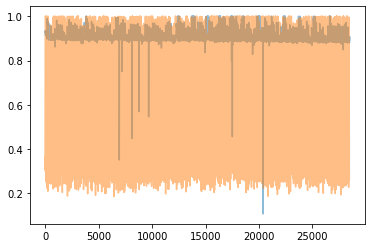

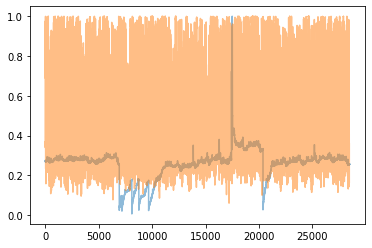

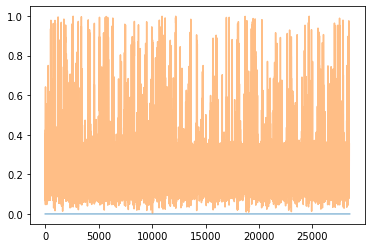

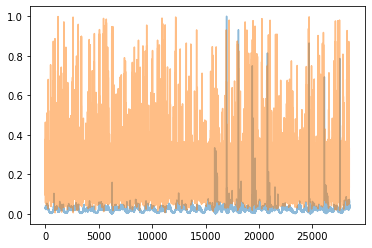

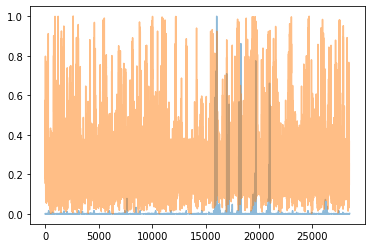

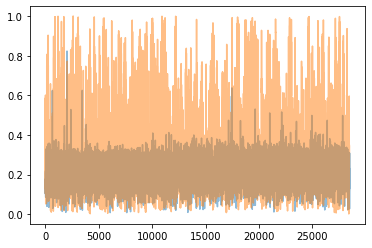

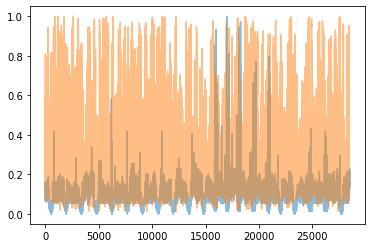

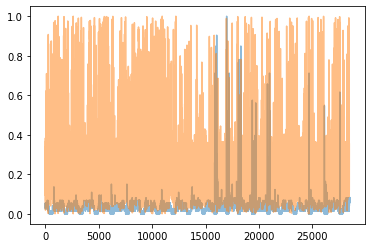

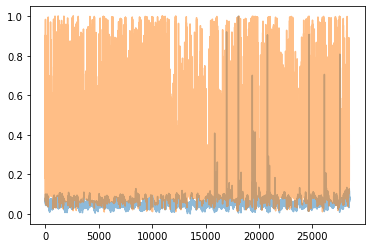

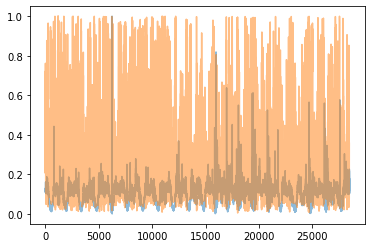

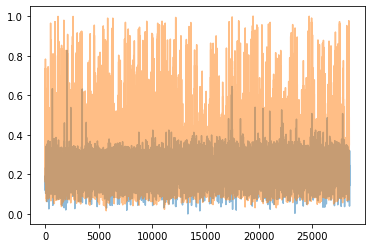

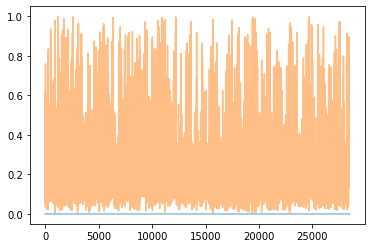

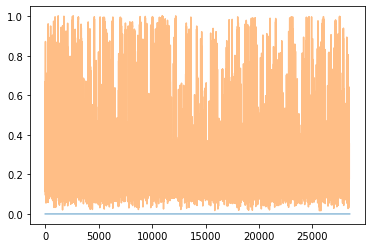

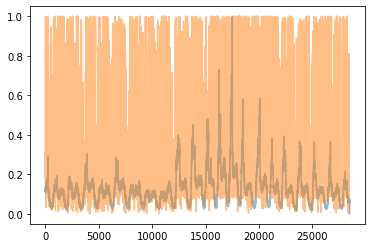

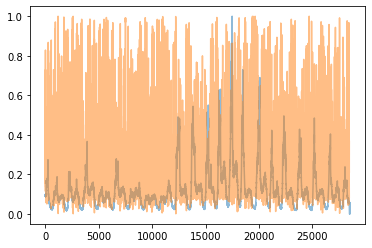

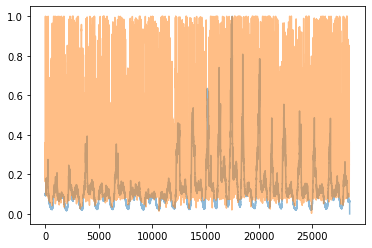

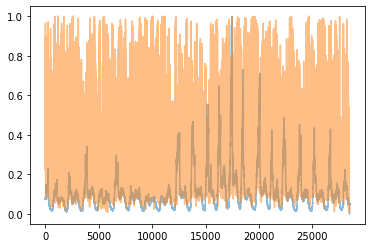

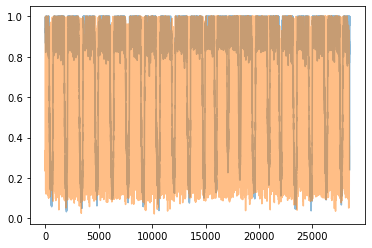

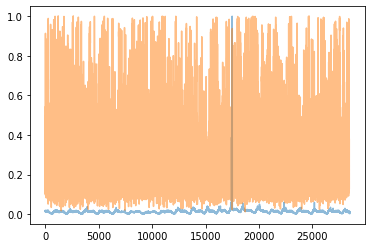

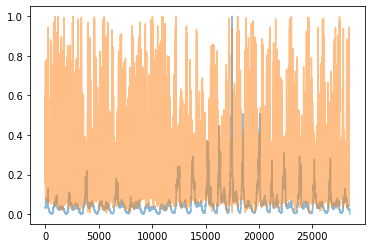

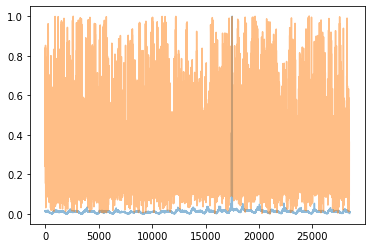

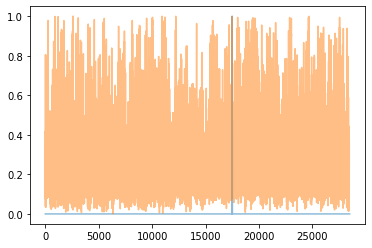

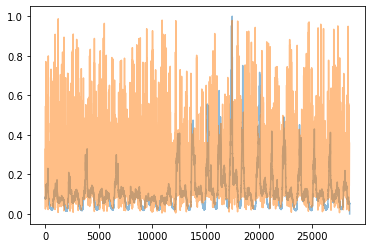

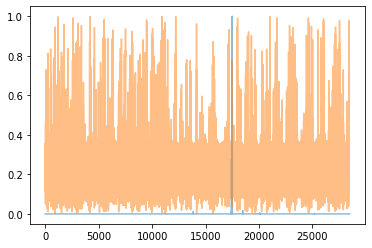

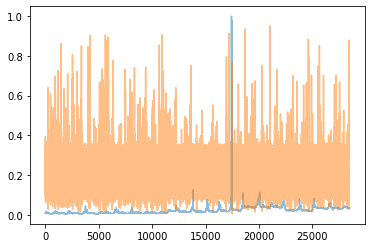

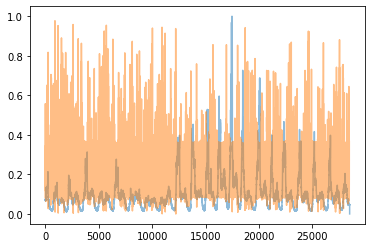

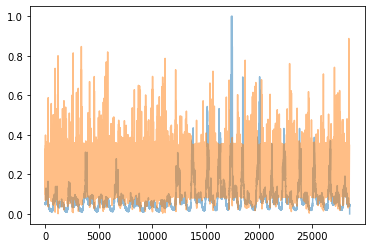

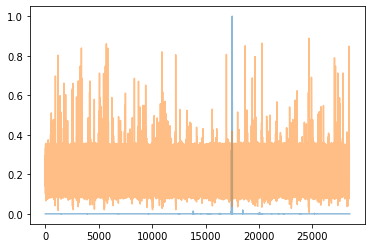

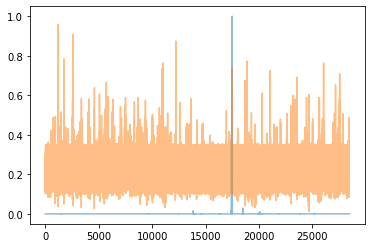

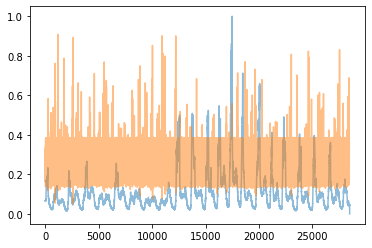

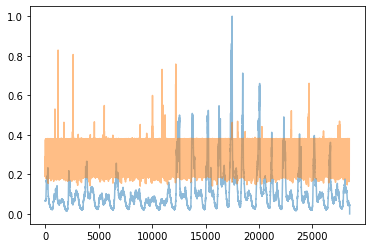

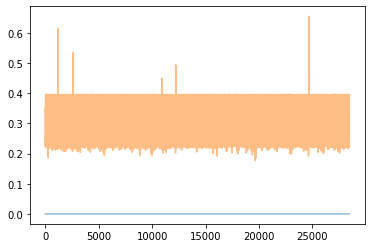

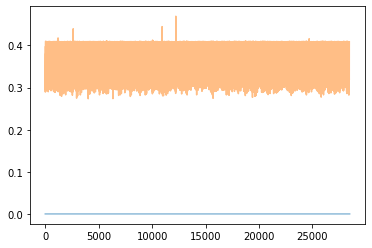

MSE : 0.07563


In [5]:
plot_train_test_reconstructions(model, X_train_tensor, X_train_data, X_test_tensor,X_test_data)

In [6]:
X_train_tensor.shape

torch.Size([889, 1, 32, 38])

In [ ]:
evaluation_utils.VAE_anomaly_detection(model, X_test_tensor, X_test_data, X_train_data, df_Y_test, .02)

Computing AUPR for 28402 thresholds ... 
